# Phonon Participation Ratios
# 1. Introduction
- In this example, we calculate the phonon participation ratios (PPR) of prsitine and defect graphene at 300 K and zero pressure.Based on the atomic phonon density of states (PDOS) [[Dickey 1969]](https://doi.org/10.1103/PhysRev.188.1407), the PPR is calculated to approximately measure the phonon localization with the following form [[Bell 1970]](https://doi.org/10.1039/DF9705000055):
$$
PPR(\omega) = \frac{1}{N} \frac{(\sum_{i}PDOS_{i}^{2}(\omega))^{2}}{\sum_{i}PDOS_{i}^{4}(\omega)},
$$
where $PDOS_{i}$ is the atomic PDOS and $N$ s the total number of atoms involved in the calculation. The specific details on the PDOS calculation can be found in our [PDOS tutorial](https://github.com/brucefan1983/GPUMD/blob/master/examples/empirical_potentials/density_of_states/Density%20of%20States.ipynb).

# 2. Preparing the Inputs
- We use a prsitine graphene consisting of 1008 carbon atoms and a defect graphene consisting of 978 carbon atoms (about 3% atomic vacancy). The atomic interactions are described by the Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

## Generate the  [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file:

- The xyz.in files for prsitine graphene and defect graphene are constructed by the python code graphene_construct.py as provided in the same path.
- The first few lines of the [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file are (taking the defect graphene as an example):
```
978 3 2.1 0 0 1 
1 1 0 51.6497550817 51.12 3.35 
0   0.614878036 0.710000001 10  12.011  0
0   1.844634109 1.420000001 10  12.011  1
0   1.844634109 2.840000002 10  12.011  2
0   0.614878036 3.549999998 10  12.011  3
0   0.614878036 4.969999999 10  12.011  4
0   1.844634109 5.679999999 10  12.011  5
```

- Explanations for the first line:
  - The first number states that the number of particles is 978.
  - The second number in this line, 3, is good for graphene described by the Tersoff potential because no atom can have more than 3 neighbor atoms at room temperature. Making this number larger only results in more memory usage. If this number is not large enough, GPUMD will give an error message and exit.
  - The next number, 2.1, means that the initial cutoff distance for the neighbor list construction is 2.1 A. Here, we only need to consider the first nearest neighbors. Any number larger than the first nearest neighbor distance and smaller than the second nearest neighbor distance is OK here. Note that we will also not update the neighbor list. There is no such need in this problem. 
  - The remaining three zeros in the first line mean:
    - the box is orthogonal;
    - the initial velocities are not contained in this file;
    - there are one grouping methods defined here.

 - Explanations for the second line:
   - The numbers 1 1 0 mean that the $x$ and $y$ (in-plane) directions are periodic and the $z$ direction is open (free).
   - The remaining three numbers are the box lengths in the three directions. The box length in a free direction is chosen based on some convention. This number will only affect the system volume.

- Starting from the third line, the numbers in the first column are all 0 here, which means that all the atoms are of type 0 (single atom-type system). The next three columns are the initial coordinates of the atoms. The penultimate column gives the masses of the atoms. The last column gives the group labels of each atom in the defined grouping method.
- It is noted that, we give each atom a distinct group label to obtain the corresponding atomic PDOS here. 

## The <code>run.in</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential       potentials/tersoff/Graphene_Lindsay_2010_modified.txt 0
velocity        300

ensemble        npt_ber 300 300 0.01 0 0 0 0.0005 
time_step       1     
dump_thermo     100  
run             200000

ensemble        nve 
compute_dos     5 200 400.0 group 0 -1 num_dos_points 300
run             200000
```
 - The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

 - The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

 - There are two runs:
   - The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage, where the NPT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen method) is used. The temperature is 300 K and the pressures are zero in all the directions. The coupling constants are 0.01 (dimensionless) and 0.0005 (in the natural unit system adopted by GPUMD) for the thermostat and the barostat, respectively. The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. There are $2\times 10^5$ steps (200 ps) for this [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) and the thermodynamic quantities will be output every 1000 steps. 
   - The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword), where the NVE [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) is used. The line with [compute_dos](https://gpumd.zheyongfan.org/index.php/The_compute_dos_keyword) means that velocities will be recorded every 5 steps (5 fs) and 200 VAC data (the maximum correlation time is then about 1 ps) will be calculated. The third parameter in this line is the maximum angular frequency considered, $\omega_{\rm max} = 2\pi\nu_{\rm max} =400$ THz, which is large enough for graphene. Here, we use "group 0 -1" here to calculate the PDOS for each atom of graphene, and "num_dos_points 300" means total 300 points for each atom will be calculated, and therefore, it is expected to obtain the PDOS data with 300 $\times$ N rows. The production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) lasts 200 ps.

# 3. Results and Discussion
### Calculate the PPR
Based on the [dos.out](https://gpumd.zheyongfan.org/index.php/The_dos.out_output_file) output files for each atom in prsitine and defect graphene, according to the PPR defined previously, we can obtain their corresponding PPR with the following codes. 

In [8]:
from pylab import *

def ppr_calc(path):
    dos_raw = np.loadtxt(path + 'dos.out')
    N = int(len(dos_raw)/300) #atom number
    dos_collect = np.zeros((300, N))
    for i in range(N):
        dos_slice = dos_raw[300*i:300*(i+1)] #Phonon DOS for each atom
        dos_xyz_slice = dos_slice[:,1] + dos_slice[:,2] + dos_slice[:,3] #We calculate the total dos
        dos_collect[:,i] = dos_xyz_slice
    ppr = np.zeros((300,2))
    ppr[:,0]=dos_raw[:300][:,0] / (2*np.pi) 
    print(trapz(sum(dos_collect,axis=1),ppr[:,0])) #equal to 3N
    for j in range(300):
        ppr[j,1] = (sum(dos_collect[j]**2))**2/sum(dos_collect[j]**4)/N
    return ppr


ppr_defect  = ppr_calc("defect_graphene/")
ppr_prsitine = ppr_calc("prsitine_graphene/")


2922.3424473811947
3017.278477666552


## Plot PPR


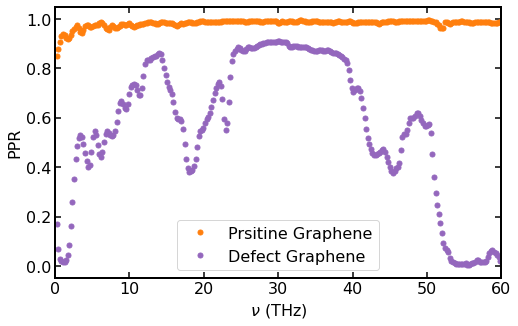

In [9]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 6
    tw = 1.5
    tlm = 3
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)
      
figure(figsize=(8, 5))
set_fig_properties([gca()])
plot(ppr_prsitine[:,0], ppr_prsitine[:,1], 
     color='C1', 
     marker="o", 
     linewidth=0,  
     markersize=5, 
     label='Prsitine Graphene')
plot(ppr_defect[:,0], ppr_defect[:,1], 
     color='C4', 
     marker="o", 
     linewidth=0,  
     markersize=5, 
     label='Defect Graphene')
xlim([0.0, 60.0])
gca().set_xticks(linspace(0,60,7))
ylim([-0.05, 1.05])
gca().set_yticks(linspace(0,1.0,6))
xlabel(r'$\nu$ (THz)')
ylabel("PPR")
legend(loc="lower center")


From the above figure, it can be clearly found that the weakening of the PPR by the defects covered the entire frequency domain, indicating a significant phonon localization effect in defect graphene when compared to the prsitine graphene counterpart.

# 4. References
- [Dickey 1969] J. M. Dickey and A. Paskin, [Computer Simulation of the Lattice Dynamics of Solids](https://doi.org/10.1103/PhysRev.188.1407), Phys. Rev. **188**, 1407 (1969).
- [Bell 1970] R. J. Bell, P. Dean, [Atomic vibrations in vitreous silica](https://doi.org/10.1039/DF9705000055), Discussions of the Faraday society **50**, 55-61 (1970).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B **39**, 5566(R) (1989).